# Visão Computacional e Deep Learning para Sensoriamento Remoto com Python


# Capítulo 02 - Classificação por pixels de imagens de satélite com Redes neurais artificiais.

A classificação de uso e cobertura da terra por pixel é um processo de atribuir rótulos ou classes específicas a cada pixel em uma imagem de sensoriamento remoto, indicando o tipo de uso ou cobertura da terra presente naquele local. Existem várias abordagens para realizar essa classificação, incluindo técnicas supervisionadas e não supervisionadas.

Técnicas Supervisionadas: Nas técnicas supervisionadas, você precisa de um conjunto de dados rotulados, onde cada pixel na imagem é atribuído a uma classe específica de uso ou cobertura da terra. Os rótulos podem ser obtidos através de levantamentos de campo, interpretação visual ou outras técnicas de sensoriamento remoto. A classificação supervisionada envolve treinar um modelo com base nesses dados rotulados e, em seguida, usar o modelo treinado para classificar novos pixels.

As técnicas supervisionadas mais comuns incluem algoritmos de aprendizado de máquina, como Random Forest, Support Vector Machines (SVM), Redes Neurais Artificiais (ANN) e outros. Esses algoritmos utilizam características extraídas dos pixels, como valores espectrais, texturas, índices de vegetação, entre outros, para realizar a classificação.

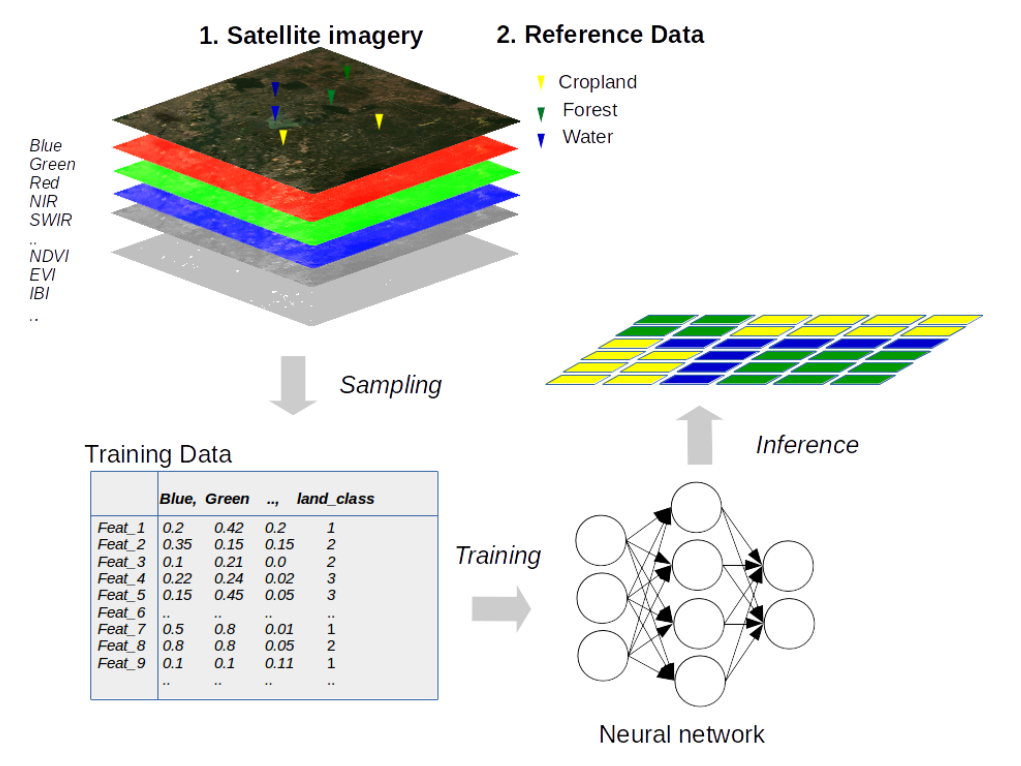

Vamos usar o MLP para realizar uma classificação pixel a pixel:

### Implementação usando o SkLearn

Primeiro instalamos e importamos os pacotes necessários:

In [ ]:
!pip install rasterio
!pip install geopandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 27.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import rasterio
import numpy as np
from matplotlib import pyplot as plt
import cv2
from matplotlib import cm
import pandas as pd
import seaborn as sns
import geopandas as gpd
from rasterio.plot import show
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap

Usaremos uma imagem Sentinel 2 com 10 bandas espectrais e com valores normalizados entre 0 e 1:

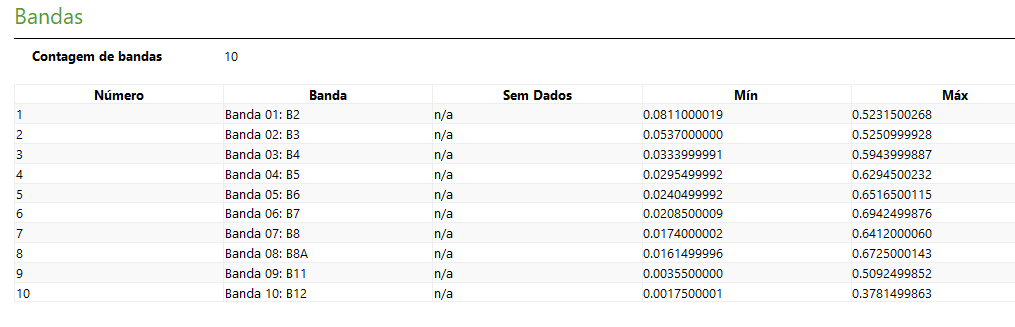

Vamos usar o rasterio para importar a imagem:

In [ ]:
path = '/content/drive/MyDrive/Datasets/LULC_Netherland/Netherlands_2021.tif'

In [ ]:
src = rasterio.open(path)
im = src.read()

In [ ]:
print(im.shape)

(10, 1571, 3701)


In [ ]:
im = im.transpose([1,2,0])

In [ ]:
im.shape

(1571, 3701, 10)

Para plotar, separamos as bandas do RGB e empilhamos em uma nova variável:

In [ ]:
R = im[:,:,2]
G = im[:,:,1]
B = im[:,:,0]

In [ ]:
rgb = np.dstack((R,G,B))

(-0.5, 3700.5, 1570.5, -0.5)

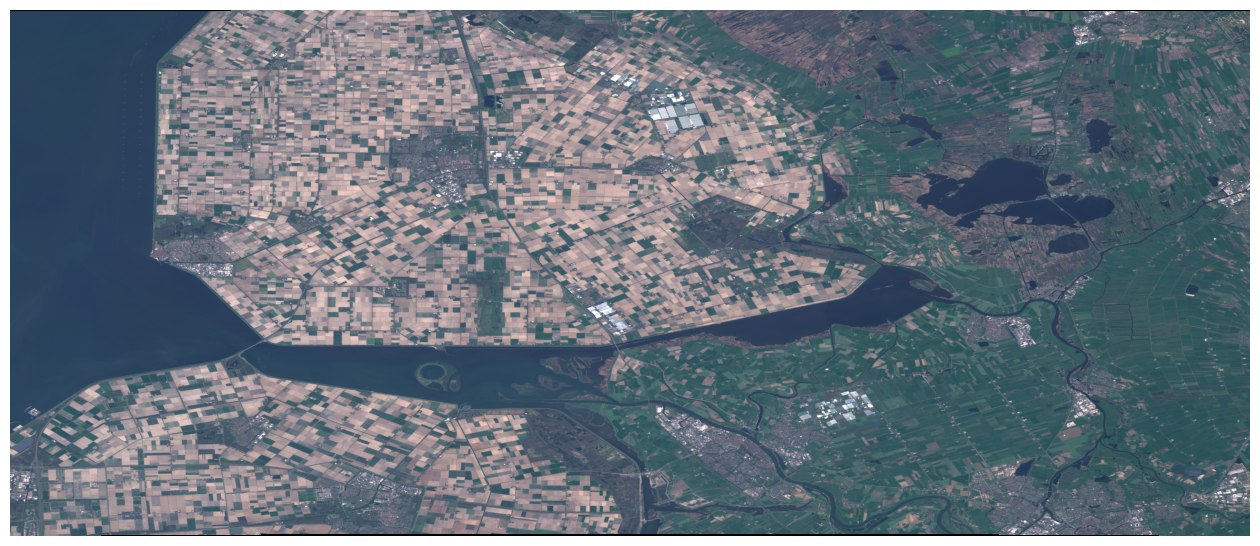

In [ ]:
plt.figure(figsize=(16,12))
plt.imshow(rgb*4)
plt.axis('off')

Vamos usar pontos que foram amostrados em 5 classes de uso e cobertura: Agua, Urbano, Floresta, Agricultura_vegetação e Agricultura_solo_exposto:

In [ ]:
samples = gpd.read_file('/content/drive/MyDrive/Datasets/LULC_Netherland/Samples.shp')

In [ ]:
samples

id                  geometry
0     1  POINT (5.53812 52.73801)
1     1  POINT (5.54938 52.69688)
2     1  POINT (5.58365 52.63372)
3     1  POINT (5.56897 52.73556)
4     1  POINT (5.56101 52.63513)
..   ..                       ...
145   5  POINT (5.95186 52.76716)
146   5  POINT (5.91306 52.77823)
147   5  POINT (5.66679 52.55724)
148   5  POINT (5.67285 52.56134)
149   5  POINT (5.72456 52.55253)

[150 rows x 2 columns]

Verificamos se a imagem e os pontos estão no mesmo sistema de coordenadas:

In [ ]:
print(samples.crs)

EPSG:4326


In [ ]:
print(src.crs)

EPSG:4326


Criamos uma nova coluna para adicionar os nomes das classes:

In [ ]:
samples['label'] = samples['id'].replace({1:'Agua', 2:'Urbano', 3:'Floresta', 4:'Agricola_Vegetaçao', 5:'Agricola_Solo'})

In [ ]:
samples

id                  geometry          label
0     1  POINT (5.53812 52.73801)           Agua
1     1  POINT (5.54938 52.69688)           Agua
2     1  POINT (5.58365 52.63372)           Agua
3     1  POINT (5.56897 52.73556)           Agua
4     1  POINT (5.56101 52.63513)           Agua
..   ..                       ...            ...
145   5  POINT (5.95186 52.76716)  Agricola_Solo
146   5  POINT (5.91306 52.77823)  Agricola_Solo
147   5  POINT (5.66679 52.55724)  Agricola_Solo
148   5  POINT (5.67285 52.56134)  Agricola_Solo
149   5  POINT (5.72456 52.55253)  Agricola_Solo

[150 rows x 3 columns]

<Axes: >

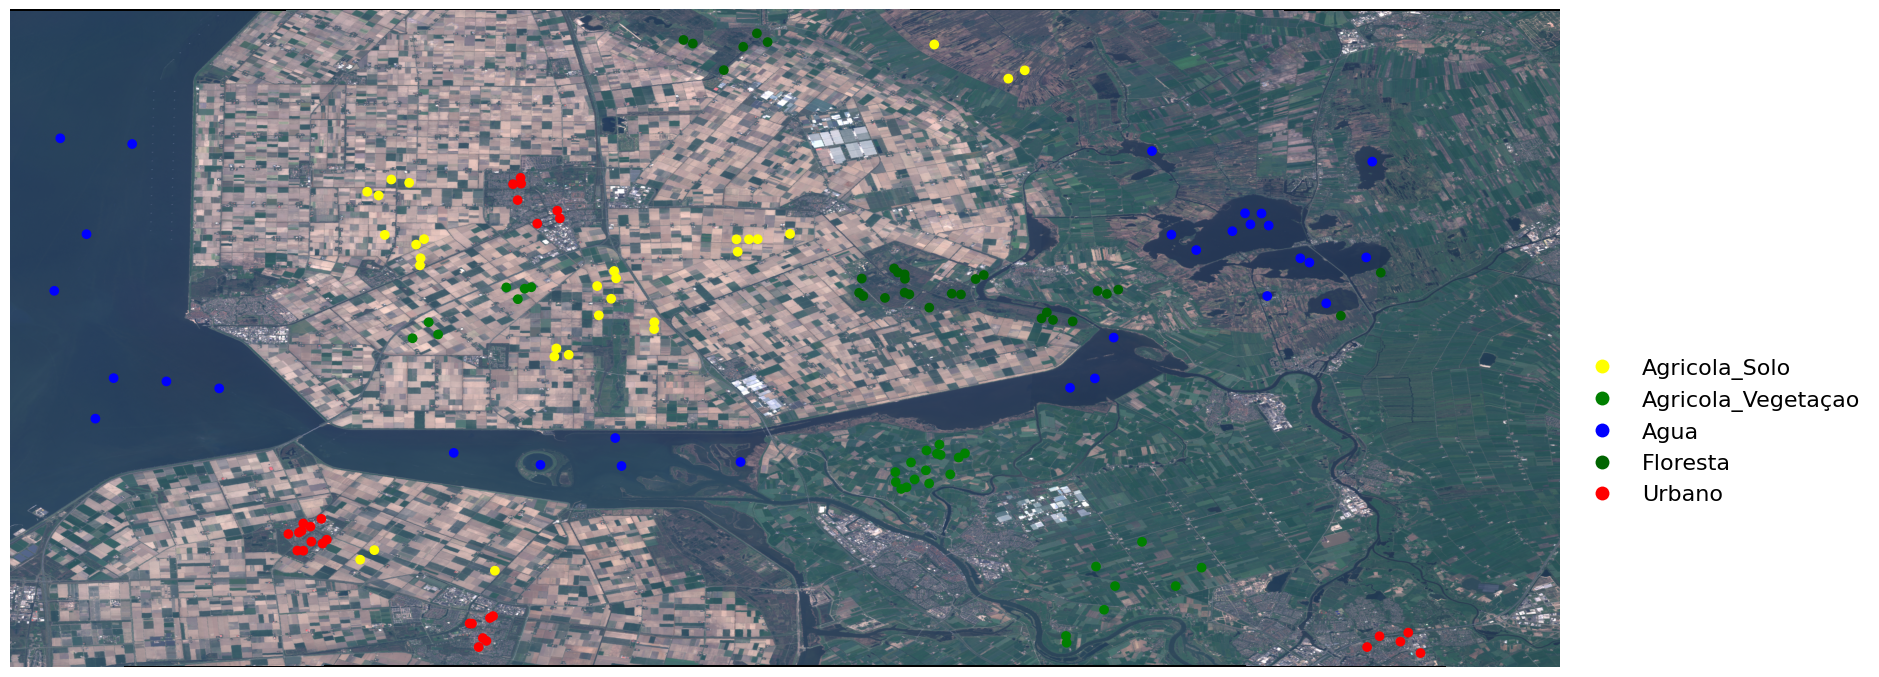

In [ ]:
cmap = ListedColormap(['yellow','green','blue','darkgreen','red'])
fig, ax = plt.subplots(figsize=(20,20))
samples.plot(column='label', categorical=True, cmap=cmap, legend=True, legend_kwds={'bbox_to_anchor':(1, 0.5),'loc':'upper left','fontsize':16,'frameon':False}, ax=ax)
ax.axis('off')
show(rgb.transpose([2,0,1])*4, transform=src.transform, ax=ax)

Assim criaremos um for para cada ponto, selecionando o valor do pixel correspondente para cada banda espectral:

In [ ]:
samples['geometry']

0      POINT (5.53812 52.73801)
1      POINT (5.54938 52.69688)
2      POINT (5.58365 52.63372)
3      POINT (5.56897 52.73556)
4      POINT (5.56101 52.63513)
                 ...           
145    POINT (5.95186 52.76716)
146    POINT (5.91306 52.77823)
147    POINT (5.66679 52.55724)
148    POINT (5.67285 52.56134)
149    POINT (5.72456 52.55253)
Name: geometry, Length: 150, dtype: geometry

In [ ]:
array_samples = []
for point in samples['geometry']:
  x = point.xy[0][0]
  y = point.xy[1][0]
  row, col = src.index(x,y)
  band_value = []
  for i in range(src.count):
    band_value.append(src.read(i+1)[row,col])
  array_samples.append(band_value)

No final convertermos a lista para um array:

In [ ]:
X = np.array(array_samples)

Esse array terá a quantidade de pontos X numero de bandas:

In [ ]:
X.shape

(150, 10)

In [ ]:
dataset = pd.DataFrame(data=X, columns=['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12'])

In [ ]:
dataset['label'] = samples['id']

In [ ]:
dataset

B2       B3       B4       B5       B6       B7       B8      B8A  \
0    0.08895  0.06430  0.03805  0.03390  0.02710  0.02410  0.02085  0.01915   
1    0.09045  0.06295  0.04010  0.03370  0.02945  0.02600  0.02240  0.01970   
2    0.08905  0.06225  0.04045  0.03430  0.02940  0.02630  0.02235  0.02055   
3    0.09050  0.06525  0.04105  0.03480  0.02830  0.02680  0.02175  0.02000   
4    0.09040  0.06080  0.03865  0.03320  0.02830  0.02590  0.02095  0.01920   
..       ...      ...      ...      ...      ...      ...      ...      ...   
145  0.13585  0.12690  0.15220  0.16930  0.24035  0.27875  0.29300  0.32295   
146  0.11155  0.09240  0.09975  0.12525  0.19760  0.23015  0.19315  0.26100   
147  0.16380  0.16275  0.18500  0.19815  0.21450  0.23335  0.21905  0.24180   
148  0.14335  0.13130  0.12980  0.15135  0.25745  0.29175  0.28280  0.30685   
149  0.14075  0.13310  0.14955  0.16235  0.18070  0.19295  0.19540  0.20715   

         B11      B12  label  
0    0.00510  0.00345      1  
1    0.00445  0.00350      1  
2    0.00535  0.00375      1  
3    0.00615  0.00425      1  
4    0.00530  0.00385      1  
..       ...      ...    ...  
145  0.26210  0.16145      5  
146  0.13890  0.08525      5  
147  0.24210  0.22695      5  
148  0.17595  0.13955      5  
149  0.21625  0.19620      5  

[150 rows x 11 columns]

O próximo passo é separar os dados espectrais do alvo:

In [ ]:
X = dataset.iloc[:,0:-1].values
Y = dataset.iloc[:,-1].values

Então vamos importar algumas funções do Sklearn:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

Como estamos trabalhando com dados categóricos, precisamos codificar valores categóricos em valores binários para que sejam compatíveis com as saídas esperadas de uma rede neural:

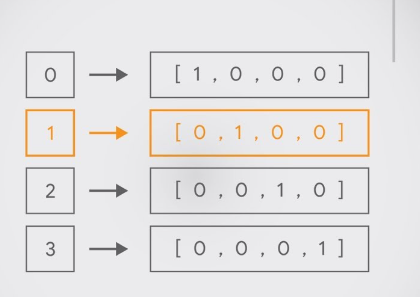

In [ ]:
new_Y = Y[:,np.newaxis]

In [ ]:
new_Y.shape

(150, 1)

In [ ]:
enc = OneHotEncoder()

enc.fit(new_Y)

onehotlabels = enc.transform(new_Y).toarray()

In [ ]:
onehotlabels.shape

(150, 5)

In [ ]:
onehotlabels

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1.

Podemos então separar os dados em treinamento e teste:

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, onehotlabels, test_size = 0.3, random_state = 42)

Vamos então criar a instância MLP usando a implementação disponível no Sklearn. As camadas ocultas terão 16, 32 e 8 neurônios. Usaremos o otimizador Adam, a função de ativação Relu e treinaremos para 100 iterações.

In [ ]:
classifier = MLPClassifier(hidden_layer_sizes=(16,32,8), max_iter=5000,activation = 'relu',solver='adam',random_state=1,verbose=10)

In [ ]:
classifier.fit(X_train, Y_train)

Iteration 1, loss = 3.87036050
Iteration 2, loss = 3.85071566
Iteration 3, loss = 3.83101681
Iteration 4, loss = 3.81124053
Iteration 5, loss = 3.79151764
Iteration 6, loss = 3.77189049
Iteration 7, loss = 3.75235660
Iteration 8, loss = 3.73289004
Iteration 9, loss = 3.71338557
Iteration 10, loss = 3.69376269
Iteration 11, loss = 3.67409729
Iteration 12, loss = 3.65444722
Iteration 13, loss = 3.63478774
Iteration 14, loss = 3.61528445
Iteration 15, loss = 3.59612260
Iteration 16, loss = 3.57791285
Iteration 17, loss = 3.56088203
Iteration 18, loss = 3.54439202
Iteration 19, loss = 3.52870800
Iteration 20, loss = 3.51382676
Iteration 21, loss = 3.49983748
Iteration 22, loss = 3.48681313
Iteration 23, loss = 3.47428713
Iteration 24, loss = 3.46232792
Iteration 25, loss = 3.45061288
Iteration 26, loss = 3.43886370
Iteration 27, loss = 3.42701062
Iteration 28, loss = 3.41497451
Iteration 29, loss = 3.40290618
Iteration 30, loss = 3.39090042
Iteration 31, loss = 3.37886731
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(16, 32, 8), max_iter=5000, random_state=1,
              verbose=10)

Depois de terminar o treinamento, vamos prever os dados do teste:

In [ ]:
y_pred = classifier.predict(X_test)

Para então calcular a acurácia:

In [ ]:
accuracy_score(Y_test, y_pred)

0.8888888888888888

In [ ]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.86      0.67      0.75         9
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00         4
           4       0.78      0.78      0.78         9

   micro avg       0.93      0.89      0.91        45
   macro avg       0.93      0.89      0.91        45
weighted avg       0.93      0.89      0.91        45
 samples avg       0.89      0.89      0.89        45



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Predição de um mapa de uso e cobertura usando o modelo treinado:

Após treinado o modelo, vamos aplicá-lo a uma imagem e gerar um mapa de uso e cobertura em formato tiff. Vamos usar a mesma imagem de treinamento, com as mesmas bandas.

In [ ]:
with rasterio.open(path) as src:
    im = src.read()

In [ ]:
out_meta = src.meta.copy()

In [ ]:
im = im.transpose([1,2,0])

In [ ]:
X = np.nan_to_num(im)

In [ ]:
flatten_X = X.reshape(X.shape[0]*X.shape[1],X.shape[2])

In [ ]:
pred = classifier.predict(flatten_X)

In [ ]:
pred

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0]])

In [ ]:
classify = np.argmax(pred, axis=1)

In [ ]:
classify = classify + 1

In [ ]:
classify = classify.reshape(X.shape[0],X.shape[1])

(-0.5, 3700.5, 1570.5, -0.5)

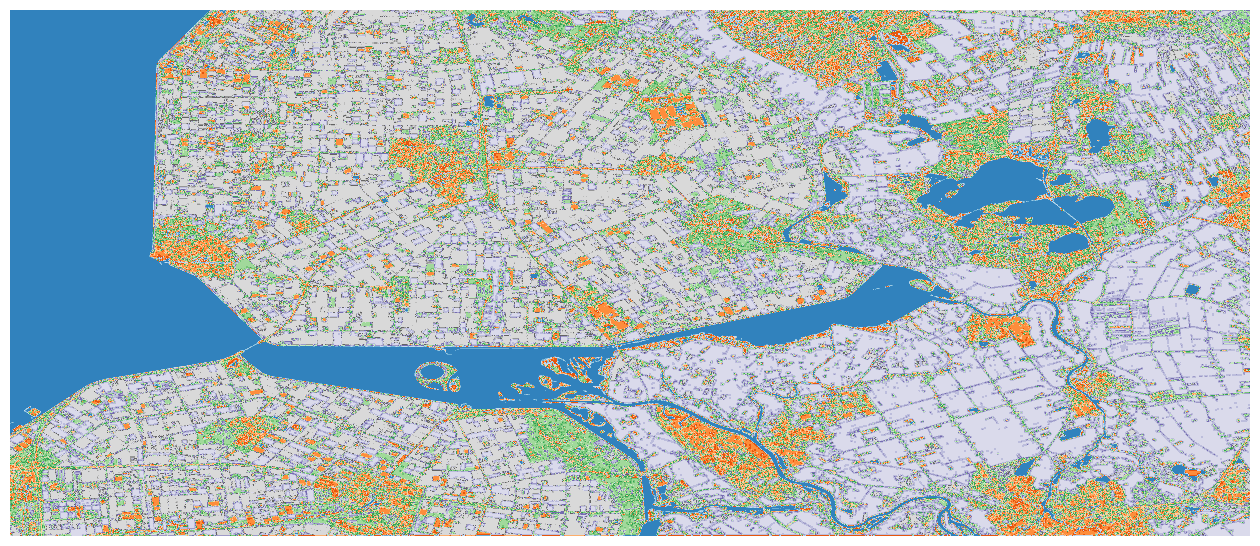

In [ ]:
plt.figure(figsize=[16,10])
plt.imshow(classify,cmap='tab20c')
plt.axis('off')

In [ ]:
export_image = classify[np.newaxis,:,:]

In [ ]:
out_meta.update({"driver": "GTiff",
                  "height": export_image.shape[1],
                  "width": export_image.shape[2],
                  "compress":'lzw',
                  "count":1
                  })

In [ ]:
with rasterio.open('/content/Netherlands_2020_LULC.tif', "w", **out_meta) as dest:
     dest.write(export_image)